## first time setup
install packages and configure NLTK

In [30]:
import sys
!{sys.executable} -m pip install pandas==1.3.5 numpy==1.24 nltk plotly ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00a 0:00:01


## main script

### setup, data loading and filtering

In [82]:
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
import os
import numpy as np
import nltk
import json
import plotly.express as px
import plotly.graph_objects as go

In [4]:
def load_dataframes(base_dir):
    dfs = []
    for f in os.listdir(base_dir):
        df = pd.read_pickle(f"{base_dir}/{f}")

        dfs.append(df)

    dataset = pd.concat(dfs)
    
    return dataset

In [5]:
def load_predefined_queries(jsonfile):
    
    f = open (jsonfile, "r")
    compdata = json.load(f)
    
    queries = {}
    
    for t in compdata["description"]["tasks"]:
        name = t["name"]
        querystr = ""
        for h in t["hints"]:
            if h["type"]=="TextHint":
                querystr = h["text"]
        queries[name] = querystr
    
    return queries
    

In [124]:
def reformat_value(x):
    txt = x["value"]
    
    prefixes = ["CLIP: ","Temporal CLIP: "]
    
    for p in prefixes:
        if txt.startswith(p):
            txt = txt[len(p):]
            
    # strip leading and trailing whitespace
    txt = txt.strip()
    
    # remove > 
    txt = txt.replace('>', '')
    
    # remove any double spaces 
    txt = txt.replace('  ', ' ')
    
    x["value"] = txt
    return x

In [7]:
dataset = load_dataframes("/data/vbse2022/data/dataframes/vbse2022_logs_dataframes/vbse2022")
dataset.shape

(31837679, 16)

In [8]:
predefinedqueries = load_predefined_queries("/data/vbse2022/data/DRES data/VBS Extended Test Nov 11, 2022.json")
print(predefinedqueries)

{'t1': 'A snowboarder falling', 't2': 'Bride walking and dancing', 'vbse001': 'A woman holding a steaming mug close to the camera.', 'vbse002': 'Viewer moving fast backwards on railway tracks.', 'vbse003': 'Close-up shot of water waves reflecting the sun.', 'vbse004': 'A woman having a mobile phone call in bed', 'vbse005': 'A red seaplane on a lake with forests around.', 'vbse006': 'Woman in yellow shirt standing in a room with a yellow sofa.', 'vbse007': 'Four people waving on a mountain summit.', 'vbse008': 'A white van driving between ruins.', 'vbse009': 'Two men running backwards up a downwards moving escalator.', 'vbse010': 'People dancing and drumming on the street at night.', 'vbse011': 'Three man and a woman riding on a covered boat.', 'vbse012': 'View of a volcano with clouds moving in from the right.', 'vbse013': 'Flashing shots of a man on a bed and in front of a wall.', 'vbse014': 'A white dress is waving in the wind over the floor.', 'vbse015': 'A man lighting at a piano w

In [9]:
textqueries = dataset.loc[dataset["category"]=="TEXT"]
textqueries.shape

(3335, 16)

In [125]:
# reformat values
textqueries = textqueries.apply(reformat_value, axis=1)

### query change events
- check if initial query changed
- add delta length of queries in characters

In [126]:
querychanges = pd.DataFrame(columns=list(textqueries.columns.values)+["delta_len"])


for task in textqueries["task"].unique():
    queries_ta = textqueries.loc[textqueries["task"]==task]
    for team in queries_ta["team"].unique():
        queries_ta_te = queries_ta.loc[queries_ta["team"]==team]
        queries_ta_te = queries_ta_te.sort_values(by=['elapsed_since_task_start_ms'])
        
        # check if query is different from previous (and first from predefined), otherwise skip
        prev_query = predefinedqueries[task]
        prev_query_len = len(prev_query)
            
        for idx in range(0,queries_ta_te.shape[0]):
            
            if queries_ta_te.iloc[idx]["value"] != prev_query:
                qlen = len(queries_ta_te.iloc[idx]["value"])
                
                row = queries_ta_te.iloc[idx]
                row["delta_len"] = qlen-prev_query_len
            
                querychanges = querychanges.append(row,ignore_index=True)

                prev_query = queries_ta_te.iloc[idx]["value"]
                prev_query_len = len(prev_query)

            
print(querychanges)

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



      shotTimeMs  videoId  rank      timestamp user     task       team  \
0            NaN      NaN   NaN  1668157303000    0  vbse001     vibro2   
1            NaN      NaN   NaN  1668157258000    0  vbse001     vibro3   
2            NaN      NaN   NaN  1668157262675    0  vbse001  cvhunter4   
3            NaN      NaN   NaN  1668157303315    0  vbse001   visione1   
4            NaN      NaN   NaN  1668157312748    0  vbse001   visione1   
5            NaN      NaN   NaN  1668157331247    0  vbse001   visione1   
6            NaN      NaN   NaN  1668157307457    0  vbse001   visione2   
7            NaN      NaN   NaN  1668157323984    0  vbse001   visione2   
8            NaN      NaN   NaN  1668157323984    0  vbse001   visione2   
9            NaN      NaN   NaN  1668157310840    0  vbse001   visione4   
10           NaN      NaN   NaN  1668157310840    0  vbse001   visione4   
11           NaN      NaN   NaN  1668157310840    0  vbse001   visione4   
12           NaN      NaN

### Plotting
- scatter plot of query change times (per task, per team)

In [116]:
def calc_scatter_coords(row,tasknames):
    row["task_index"] = tasknames.index(row["task"])
    row["sec"] = row["elapsed_since_task_start_ms"]/1000
    row["secsubm"] = row["correct_submission_time_ms"]/1000
    row["entrytype"] = "query"
    
    return row
    

def scatterplot_times_per_task_team(plotdata):

    scatterdata = plotdata
    tasknames = list(scatterdata["task"].unique())
    tasknames.sort()
    
    scatterdata = scatterdata.apply(lambda x: calc_scatter_coords(x,tasknames), axis=1)
    
    # copy entries that have a submission row
    submdata = scatterdata.loc[np.logical_not(np.isnan(scatterdata["secsubm"]))]
    submdata["entrytype"] = "submission"
    submdata["sec"] = submdata["secsubm"]
    
    scatterdata = scatterdata.append(submdata)
    
    fig = px.scatter(scatterdata, x="sec", y="task_index",color="team",symbol="entrytype",symbol_sequence= ['circle', 'square-open'],
                    labels={
                     "sec": "Time from task start [s]",
                     "task_index": "Task",
                     "team": "Team"
                     },
                     height = 1000,
                     title="Times of query changes and submission per task and team",
                     )

    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = list(range(len(tasknames))),
            ticktext = tasknames,
        )
    )
    
    fig.show()

/tmp/ipykernel_30977/1502318911.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_30977/1502318911.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



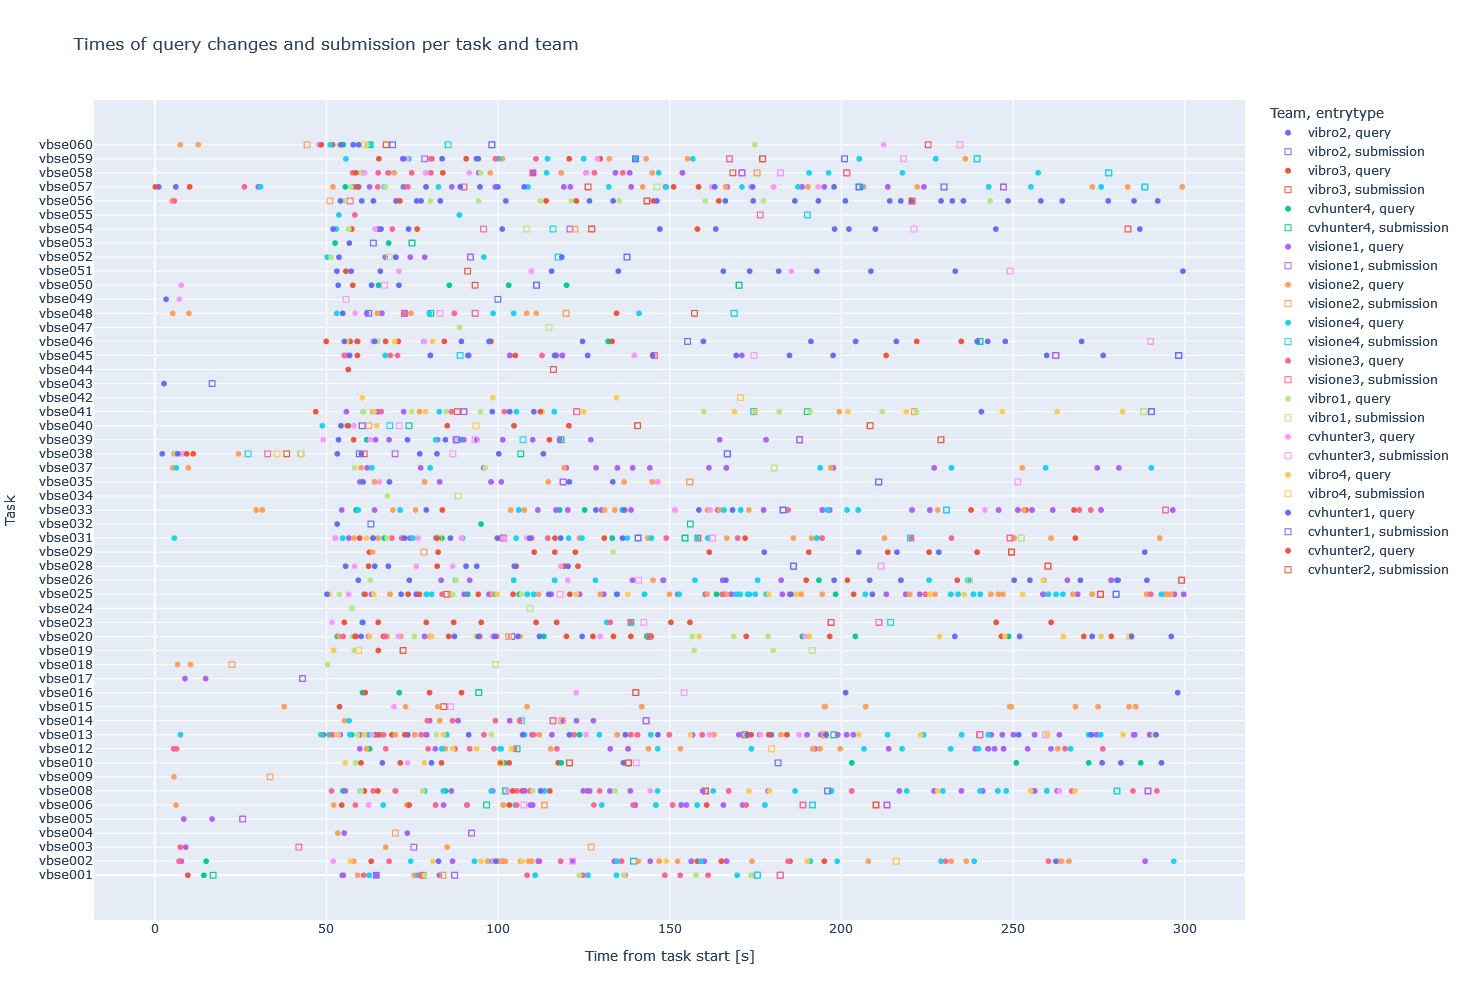

In [127]:

scatterplot_times_per_task_team(querychanges)